In [3]:
from networks.vae_mpnet import VAEMPNet
import torch
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sst_envs.utils import load_data, visualize_point

In [20]:
setup = 'default_norm_vae'
mpnet = VAEMPNet(ae_input_size=32, ae_output_size=1024, in_channels=1, state_size=4)


# setup = "default_norm_noaug_control"
# setup = "norm_nodiff_noaug_20step2e-2_control"
# mpnet = MPNet(ae_input_size=32, ae_output_size=128, in_channels=1, state_size=4, control_size=2)

model = "acrobot_obs"
env = 0
traj_id = 100
goal_radius = 5


mpnet.load_state_dict(torch.load('output/acrobot_obs/{}/ep5000'.format(setup)))
# mpnet.eval()
mpnet.train()

def plan(start_th, goal_th, env_vox, mpnet):
    start_goal = torch.cat((start_th.float(), goal_th.float()), dim=1)
    with torch.no_grad():
        sample = mpnet(start_goal, env_vox,0.5)         
    return sample.clone()

def visualize(path, start, goal, ax, color='skyblue'):
    path = np.array(path)
    ax.scatter(start[0], start[1], color='orange')
    ax.scatter(goal[0], goal[1], color='red')
    ax.plot(path[:, 0], path[:, 1], color=color)
    ax.scatter(path[:, 0], path[:, 1], color='blue', s=3)
    ax.scatter(path[-1, 0], path[-1, 1], color='orange')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

def distance(point1, point2):
    LENGTH = 20.
    x = np.cos(point1[0] - np.pi / 2)+np.cos(point1[0] + point1[1] - np.pi / 2)
    y = np.sin(point1[0] - np.pi / 2)+np.sin(point1[0] + point1[1] - np.pi / 2)
    x2 = np.cos(point2[0] - np.pi / 2)+np.cos(point2[0] + point2[1] - np.pi / 2)
    y2 = np.sin(point2[0] - np.pi / 2)+np.sin(point2[0] + point2[1] - np.pi / 2)
    return LENGTH*np.sqrt((x-x2)**2+(y-y2)**2)
env_vox_all = torch.from_numpy(np.load('sst_envs/{}_env_vox.npy'.format(model))).float()
env_vox = env_vox_all[env].float().unsqueeze(0)
ref_path_dict = load_data(model, env, traj_id)
ref_path = ref_path_dict['path']
ref_sg = ref_path_dict['start_goal']

0 tensor(64.8461)
1 tensor(63.0515)
2 tensor(61.0070)
3 tensor(58.8374)
4 tensor(35.8159)
5 tensor(27.4751)
6 tensor(26.9723)
7 tensor(28.8386)
8 tensor(11.5463)
9 tensor(18.1304)
10 tensor(18.9335)
11 tensor(41.0179)
12 tensor(7.5139)
13 tensor(10.4961)
14 tensor(9.8517)
15 tensor(15.7509)
16 tensor(17.0931)
17 tensor(10.2576)
18 tensor(8.8402)
19 tensor(10.1254)
20 tensor(11.6550)
21 tensor(13.4407)
22 tensor(14.2084)
23 tensor(18.1670)
24 tensor(29.1100)
25 tensor(27.4241)
26 tensor(26.9583)
27 tensor(21.4237)
28 tensor(16.8396)
29 tensor(15.2120)
29


<IPython.core.display.Javascript object>


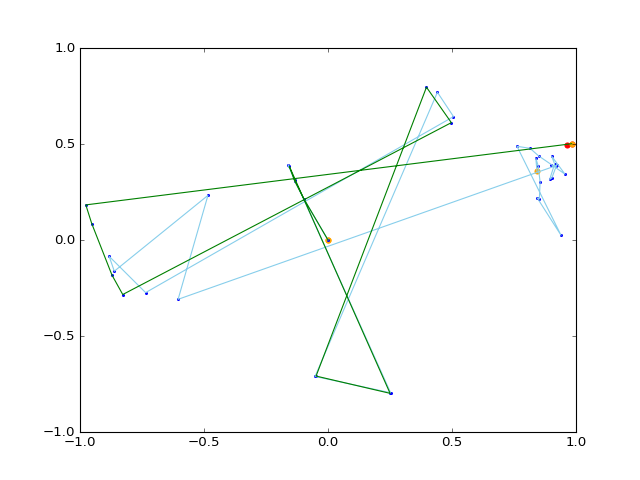

In [21]:
path = []
start = ref_path[0].copy()
# goal = ref_path[-1].copy()
goal = ref_sg[-1].copy()
start[:2] /= np.pi
start[2:] /= 6
goal[:2] /= np.pi
goal[2:] /= 6

start_th = torch.from_numpy(start).unsqueeze(0).float()
goal_th = torch.from_numpy(goal).unsqueeze(0).float()

endeff = [[0, -40]]
node1 = [[0, -20]]
path.append(start_th[0].numpy())
for i in range(30):
    dis = distance(start_th[0] * torch.tensor([np.pi, np.pi, 6, 6]), goal_th[0] * torch.tensor([np.pi, np.pi, 6, 6]))
    print(i,dis)
    if dis < goal_radius:    
        break
    sample = plan(start_th, goal_th, env_vox, mpnet)
    start_th = sample[:, :4].clone()
    if start_th[:, 0] > 1:
        start_th[:, 0] -= 2
    if start_th[:, 0] < -1:
        start_th[:, 0] += 2
        
    if start_th[:, 1] > 1:
        start_th[:, 1] -= 2
    if start_th[:, 1] < -1:
        start_th[:, 1] += 2
        
    if start_th[:, 2] > 1:
        start_th[:, 2] = 1
    if start_th[:, 2] < -1:
        start_th[:, 2] = -1
    
    if start_th[:, 3] > 1:
        start_th[:, 3] = 1
    if start_th[:, 3] < -1:
        start_th[:, 3] = -1
    
    ex1, ey1, ex2, ey2 = visualize_point(start_th.clone()[0] * torch.tensor([np.pi, np.pi, 6, 6]))
    endeff.append([ex2, ey2])
    node1.append([ex1, ey1])
    path.append(start_th[0].numpy().copy())
print(i)
%matplotlib notebook
fig1, ax1 = plt.subplots()


path_from_data = ref_path.copy()
path_from_data[:, :2] /= np.pi
path_from_data[:, 2:] /= 6
# #path_from_data = data[0:150, 1:]
visualize(path, start, goal, ax1)

visualize(path_from_data, path_from_data[0], path_from_data[-1], ax1, color='green')



In [22]:
path = np.array(path)[:, :4]
path[:, :2] *= np.pi
path[:, 2:] *= 6
np.save('mpnet_path.npy', path)

<IPython.core.display.Javascript object>


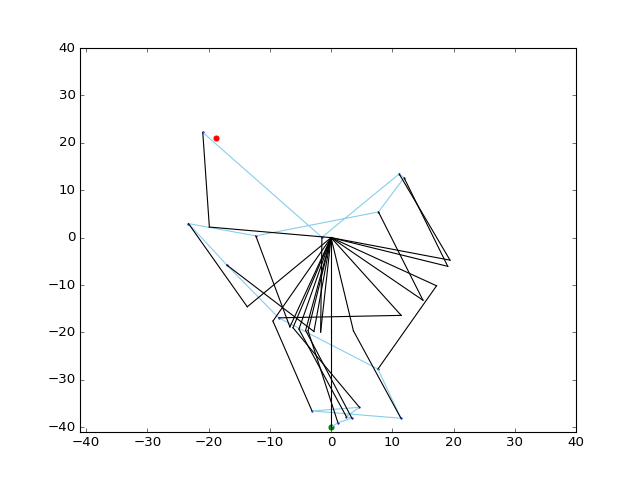

(-41, 40)

In [18]:
%matplotlib notebook
endeff = np.array(endeff)
node1 = np.array(node1)
x1, y1, x2, y2 = visualize_point(ref_path[-1])
plt.plot(endeff[:,0], endeff[:,1], color='skyblue')
plt.scatter(endeff[:,0], endeff[:,1], color='blue', s=1)

for i in range(endeff.shape[0]):
    plt.plot([0, node1[i,0]], [0, node1[i,1]], color='black')
    plt.plot([node1[i,0], endeff[i,0]], [node1[i,1], endeff[i,1]], color='black')

plt.scatter(endeff[0, 0], endeff[0, 1], color='green')
plt.scatter(x2, y2, color='red')
plt.xlim(-41, 40)
plt.ylim(-41, 40)


In [30]:
node_id = 5
start = ref_path[node_id].copy()
gt = ref_path[node_id+1].copy()
# goal = ref_path[-1].copy()
goal = ref_sg[-1].copy()
start[:2] /= np.pi
start[2:] /= 6
goal[:2] /= np.pi
goal[2:] /= 6

num_sample = 10

start_th = torch.from_numpy(start).unsqueeze(0).float().repeat([num_sample,1])
goal_th = torch.from_numpy(goal).unsqueeze(0).float().repeat([num_sample,1])

sample = plan(start_th, goal_th, env_vox.repeat([num_sample, 1, 1, 1]), mpnet)

<IPython.core.display.Javascript object>


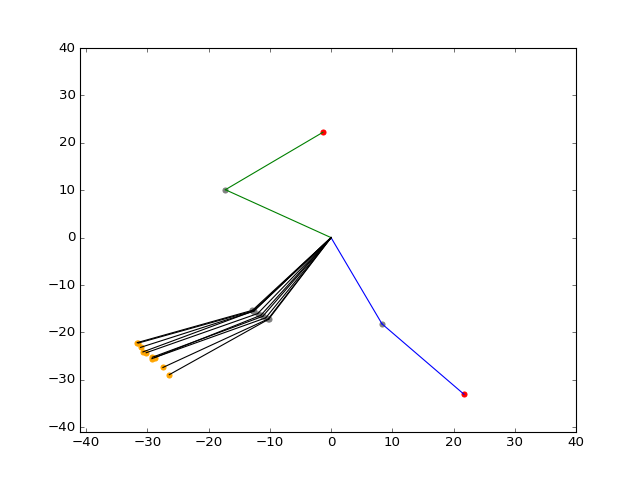

(-41, 40)

In [18]:
%matplotlib notebook

x1, y1, x2, y2 = visualize_point(start)
plt.plot([0, x1], [0, y1], color='blue')
plt.plot([x1, x2], [y1, y2], color='blue')
plt.scatter(x1, y1, color='gray')
plt.scatter(x2, y2, color='red')


x1, y1, x2, y2 = visualize_point(gt)
plt.plot([0, x1], [0, y1], color='green')
plt.plot([x1, x2], [y1, y2], color='green')
plt.scatter(x1, y1, color='gray')
plt.scatter(x2, y2, color='red')

for i in range(sample.size(0)):
    x1, y1, x2, y2 = visualize_point(sample[i])
    plt.plot([0, x1], [0, y1], color='black')
    plt.plot([x1, x2], [y1, y2], color='black')
    plt.scatter(x1, y1, color='gray')
    plt.scatter(x2, y2, color='orange')
plt.xlim(-41, 40)
plt.ylim(-41, 40)

In [12]:
# fig2, ax2 = plt.subplots()
# visualize(ref_path, ref_path[0], ref_path[-1], ax2)

In [16]:
# data = np.load("sst_envs/acrobot_obs_path_data.npy")
# gt = np.load("sst_envs/acrobot_obs_gt.npy")
# data[0:29, 1:], gt[0:29]

In [18]:
# fig2, ax2 = plt.subplots()
# p = data[0:130, 1:4+1]
# visualize(p, p[0], p[-1], ax2)

In [19]:
# fig2, ax2 = plt.subplots()
# p = data[29:59, 1:4+1]
# visualize(p, p[0], p[-1], ax2)


In [24]:
i = 6
start_goal_th = torch.from_numpy(data[i:i+1,1:]).float()
target_th = torch.from_numpy(gt[i:i+1,:]).float()
with torch.no_grad():
    sample = mpnet(start_goal_th, env_vox.unsqueeze(0))   
sample, target_th, torch.nn.functional.mse_loss(sample, target_th)

(tensor([[-0.1174,  0.0124, -0.5387,  0.8546]]),
 tensor([[-0.1140,  0.0667, -0.3536,  0.6860]]),
 tensor(1.00000e-02 *
        1.6419))

In [212]:
c = ref_path_dict['cost']


In [213]:
c

array([0.54, 1.04, 0.18, 0.2 , 1.8 , 1.08])